In [2]:
import numpy as np
import pandas as pd
import os
import string


# Converting text file data to csv file

In [2]:
os.listdir('dataset')

['ham', 'housing', 'spam']

In [151]:
# converting data to a csv file
labels = []
emails = []
not_read = 0
for folder in ['ham','spam']:
    for file in os.listdir(os.path.join('dataset',folder)):
        f = open(os.path.join('dataset',folder,file),'r')
        try:
            emails.append(f.read())
            labels.append(folder)
        except:
            not_read+=1
print(f'Files not read: {not_read}')
        
        

Files not read: 262


In [15]:
len(emails),len(labels)

(3686, 3686)

In [23]:
# saving data as .csv
df_dict = {'emails':emails,'labels':labels}
emails_df = pd.DataFrame(df_dict)
emails_df.head()

In [34]:
emails_df.to_csv('emails.csv',index=False)

# Preprocessing data

In [3]:
df = pd.read_csv('emails.csv') # laoding data

In [4]:
# adding an attribute of email length
email_length=[]
for m in df.emails:
    email_length.append(len(m))
df['email_length'] = email_length

**1: Ham <br>
    0:Spam**

In [27]:
df['labels'] = (df['labels'] == 'ham').astype(int) 

In [28]:
# splitting data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df[['emails','email_length']],df['labels'],test_size=0.2)

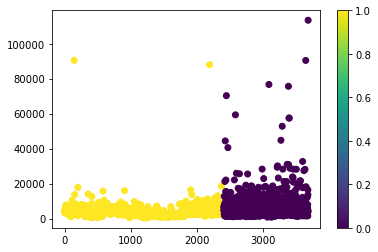

In [109]:
import matplotlib.pyplot as plt
plt.scatter(list(range(len(df))),df['email_length'],c=df['labels'])
plt.colorbar()

In [75]:
from sklearn.base import TransformerMixin, BaseEstimator
import string
from nltk.stem.porter import PorterStemmer
import re
import enchant
# Custom transformer that cleans emails, such as removing punctuations and email ids

class email_preprocessor(TransformerMixin,BaseEstimator): # TranformerMixin helps in calling fit_transform directly
    
    def __init__(self,remove_numbers=True,remove_punctuations = True,remove_email_ids=True):
        self.remove_numbers = remove_numbers # replace a number with string 'NUMBER' if true
        self.remove_punctuations = remove_punctuations # removes all punctuations if true
        self.remove_email_ids = remove_email_ids # removes all email ids if true
        self.porter_stemmer  = PorterStemmer() # porter stemmer object
        self.d = enchant.Dict("en_US") # enchant checks if a word exists in english dictionary or not

    def replace_numbers(self,x):
        '''
        Simply replaces digits with string 'NUMBER'
        '''
        res = []
        for wrd in x.split():
            if wrd.isdigit():
                res.append('NUMBER')
            else:
                res.append(wrd)
        
        return ' '.join(res)
    
    def replace_puncs(self,x):
        '''
        removes punctuations from string and returns it
        '''
        return x.translate(str.maketrans('', '', string.punctuation))
    
    def rmv_emailIds(self,x):
        '''
        Removes string with @ and .com, i.e. email ids
        '''
        return ' '.join([' ' if "@" and '.com' in wrd else wrd for wrd in x.split()])
    
    def remove_noise(self,x):
        '''
        removing strings such as gjis9sf2j and string longer than 15 characters
        '''
        # this regex collects all words that do not contain number in them
        noise = re.findall('([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)', x)
        
        # remove words with length greater than 15
        x_clean = ' '.join(wrd for wrd in x.split() if len(wrd) < 15)
        return ' '.join(set(x_clean.split()) - set(noise))
    
    def fit(self,X,y=None):
        return self # does nothing
    def lowercase(self,x):
        return x.lower()
    
    def transform(self,X,y=None):
        '''
        Transform emails and clean them
        '''
        temp= X.copy() # genrating a copy
        result = {} # stores our final result
        
        # Firstly remove email ids
        if self.remove_email_ids:
            temp=temp.apply(self.rmv_emailIds)
        
        # Second, remove punctuations
        if self.remove_punctuations:
            temp = temp.apply(self.replace_puncs)
        
        # Third, remove numbers
        if self.remove_numbers:
            temp = temp.apply(self.replace_numbers)
        
        # lastly remove all noisy data
        temp = temp.apply(self.remove_noise)
        # lowercase
        temp = temp.apply(self.lowercase)
        result['emails'] = temp
        return pd.DataFrame(result)
            

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# preprocesses all data and returns a vectorize data
def Preprocess_data(df,vectorizer,scaler,train=False):
    email_prep = email_preprocessor() # initializing object
    df['processed_emails'] = email_prep.fit_transform(df.emails) # proccessed emails
    
    # if train is true than fit vectorizer on training data
    if train:
        emails_vect = vectorizer.fit_transform(df.processed_emails.values).toarray()
#         df['scaled_email_len']=scaler.fit_transform(df['email_length'].values.reshape(-1,1))
    # else transform test data
    else:
        emails_vect = vectorizer.transform(df.processed_emails.values).toarray()
#         df['scaled_email_len']=scaler.transform(df['email_length'].values.reshape(-1,1))

    # appending scaled values of length  data to vectorized data
#     final_data = np.hstack((emails_vect, np.atleast_2d(df.scaled_email_len.values).T))
    
    return emails_vect

In [114]:
vectorizer = CountVectorizer()
scaler = StandardScaler() # scaler
# transforming training data 
X_train_prep = Preprocess_data(X_train,vectorizer=vectorizer,scaler=scaler,train=True)

In [115]:
X_train_prep.shape

(2948, 35807)

In [116]:
# transforming test data
X_test_prep = Preprocess_data(X_test,vectorizer=vectorizer,scaler=scaler,train=False)

In [117]:
X_test_prep.shape

(738, 35807)

In [118]:
# using softmax regression to classify this data
from sklearn.linear_model import LogisticRegression

# setting multi_class to mulinimial it makes logistic regressing  softmax regression
log_reg = LogisticRegression(multi_class='multinomial') 

In [119]:
log_reg.fit(X_train_prep,y_train)

LogisticRegression(multi_class='multinomial')

In [120]:
log_reg.classes_

array([0, 1])

In [121]:
from sklearn.metrics import precision_score,recall_score
y_preds = log_reg.predict(X_test_prep)
print(f'Precision: {precision_score(y_test,y_preds)} \n Recall: {recall_score(y_test,y_preds)}')

Precision: 1.0 
 Recall: 1.0


In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test,y_pred=y_preds)

array([[249,   0],
       [  0, 489]])

In [123]:
def predict_hamORspam(emails):
    length = []
    for m in emails:
        length.append(len(m))
        
    data = pd.DataFrame(emails,columns=['emails'])
    data['email_length'] = length
    prc_data = Preprocess_data(data,vectorizer,scaler)
    pred = log_reg.predict(prc_data)
    return pred

In [124]:
predict_hamORspam(['hell obuddy'])

array([0])

In [125]:
mail = '''Thank you for registering for your IELTS test with the British Council and accepting the IELTS Terms and Conditions and the IELTS Information for Candidates booklet (which includes the test malpractice and disqualification policies of IELTS which we strongly encourage test takers to read). We acknowledge receipt of your registration. No legally binding agreement will, however, be formed between you and us until we have sent you an order confirmation stating this. We shall send you an order confirmation once we have successfully received the relevant materials from you and processed your payment.
A place is being held for you at the test location below and will only be confirmed once your payment has been successfully processed. We will let you know via email acknowledgements when your payment has been successfully processed. A separate email confirmation will be sent to you when your completed application has been accepted and you can sit the test and a legally binding agreement between you and us will have been formed.'''